In [1]:
import pickle 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import scipy.io
from cv2 import  copyMakeBorder, flip, BORDER_CONSTANT

from keras.models import Sequential
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, BatchNormalization, Dropout

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importing joints locations and images - correcting size of the images

In [2]:
coords_file_name = "/content/drive/My Drive/Deep/HW02/lsp_dataset/joints.mat"
joints = scipy.io.loadmat(coords_file_name)
joints = joints['joints'][:2,:]

image_list = []

for i in range(1,2001):
  if np.mod(i,200)==0:
    print(i)
  if i<10:
    img_name = "im000{0}.jpg".format(i)
  elif i<100:
    img_name = "im00{0}.jpg".format(i)
  elif i<1000:
    img_name = "im0{0}.jpg".format(i)
  else:
    img_name = "im{0}.jpg".format(i)

  img = plt.imread("/content/drive/My Drive/Deep/HW02/lsp_dataset/images/{0}".format(img_name))

  if img.shape[0] < 220:
    height = 220 - img.shape[0]
  else:
    height = 0

  if img.shape[1] < 220:
    width = 220 - img.shape[1]
  else:
    width = 0
  
  if np.mod(width,2) == 0:
    extra_width = 0
  else:
    extra_width = 1

  if np.mod(height,2) == 0:
    extra_height = 0
  else:
    extra_height = 1

  joints[0,:,i-1] = (joints[0,:,i-1] + width/2)/220
  joints[1,:,i-1] = (joints[1,:,i-1] + height/2)/220

  img = copyMakeBorder(img,int(height/2)+extra_height,int(height/2),int(width/2)+extra_width,int(width/2),BORDER_CONSTANT,value=[0,0,0])

  image_list.append(img/255)

200
400
600
800
1000
1200
1400
1600
1800
2000


### Data Agmuntation

In [3]:
for i in range(0,2000):
  img = image_list[i]
  img = flip(img,1)
  new_coords = joints[:,:,i]
  new_coords[0,:] = (220 - 220*new_coords[0,:])/220
  joints = np.dstack((joints, new_coords))
  image_list.append(img)

print(new_coords.shape)
print(joints.shape)

(2, 14)
(2, 14, 4000)


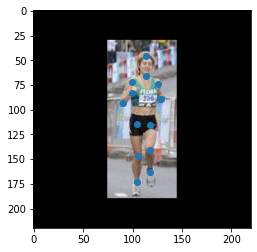

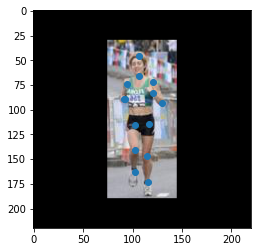

In [32]:
img = image_list[0]
plt.imshow(img)
plt.scatter(joints[0,:,0]*220, joints[1,:,0]*220)
plt.figure()
plt.imshow(flip(img,1))
plt.scatter(220 - joints[0,:,0]*220, joints[1,:,0]*220)

### Separating train, test, and validation

In [4]:
num_train = 3500
num_validation = 250

X_train = np.array(image_list[0:num_train])
Y_train = np.array(joints[:,:,0:num_train])

X_train = np.reshape(X_train,(num_train,220,220,3))
Y_train = np.transpose(np.reshape(Y_train,(28,num_train)))

X_validation = image_list[num_train:num_train+num_validation]
Y_validation = joints[:,:,num_train:num_train+num_validation]

X_validation = np.reshape(X_validation,(num_validation,220,220,3))
Y_validation = np.transpose(np.reshape(Y_validation,(28,num_validation)))

X_test = image_list[num_train+num_validation:]
Y_test = joints[:,:,num_train+num_validation:]

X_test = np.reshape(X_validation,(num_validation,220,220,3))
Y_test = np.transpose(np.reshape(Y_test,(28,num_validation)))

### Running The DNN

In [ ]:
batch_size = 128
epochs_number = 120
learning_rate = 5e-5
momentum = 0.9


model = tf.keras.models.Sequential()

model.add(Conv2D(48, (11, 11), activation='relu', strides=4, kernel_initializer='he_uniform', padding='same',  input_shape=(220, 220, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (5, 5), activation='relu', strides=2, kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(192, (3, 3), activation='relu', strides=1, kernel_initializer='he_uniform', padding='same'))

model.add(Conv2D(192, (3, 3), activation='relu', strides=1, kernel_initializer='he_uniform', padding='same'))

model.add(Conv2D(192, (3, 3), activation='relu', strides=1, kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), padding='same'))

model.add(Flatten())

model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(28, activation='linear'))

def soft_acc(y_true, y_pred):
    return tf.keras.backend.mean(tf.keras.backend.equal(tf.keras.backend.round(y_true), tf.keras.backend.round(y_pred)))

def l2_loss(y_true, y_pred):
  x_diff =  y_true[0:14] - y_pred[0:14]
  y_diff =  y_true[14:28] - y_pred[14:28]
  diff = tf.math.pow(x_diff,2) + tf.math.pow(y_diff,2)
  return tf.keras.backend.sum(diff)


optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss=l2_loss , optimizer=optimizer, metrics=[soft_acc])
model.fit(X_train, Y_train, epochs=epochs_number, batch_size=batch_size, validation_data=(X_validation, Y_validation))

# test_results = model.evaluate(X_test, Y_test, verbose=1)
# print('\n', "Test results - Loss: {0:.2f} - Accuracy: {1:.2f}%".format(test_results[0],test_results[1]))

In [9]:
epochs_number = 480*2
model.fit(X_train, Y_train, epochs=epochs_number, batch_size=batch_size, validation_data=(X_validation, Y_validation), initial_epoch=240*2)

Epoch 481/960
11/11 [==============================] - 2s 210ms/step - loss: 3.7425 - soft_acc: 0.7931 - val_loss: 9.5078 - val_soft_acc: 0.6619
Epoch 482/960
11/11 [==============================] - 2s 165ms/step - loss: 3.8745 - soft_acc: 0.7917 - val_loss: 9.8828 - val_soft_acc: 0.6635
Epoch 483/960
11/11 [==============================] - 2s 148ms/step - loss: 3.5074 - soft_acc: 0.8009 - val_loss: 9.5002 - val_soft_acc: 0.6681
Epoch 484/960
11/11 [==============================] - 2s 162ms/step - loss: 3.6181 - soft_acc: 0.7961 - val_loss: 9.2363 - val_soft_acc: 0.6652
Epoch 485/960
11/11 [==============================] - 2s 151ms/step - loss: 3.8462 - soft_acc: 0.7950 - val_loss: 9.7666 - val_soft_acc: 0.6665
Epoch 486/960
11/11 [==============================] - 2s 162ms/step - loss: 3.5560 - soft_acc: 0.7972 - val_loss: 9.6191 - val_soft_acc: 0.6665
Epoch 487/960
11/11 [==============================] - 2s 147ms/step - loss: 3.6656 - soft_acc: 0.8003 - val_loss: 9.5056 - val_so

KeyboardInterrupt: ignored

In [17]:
print(X_train.shape)
test = model.predict(X_validation)

(1400, 220, 220, 3)


In [30]:
print(test.shape)

(1400, 28)


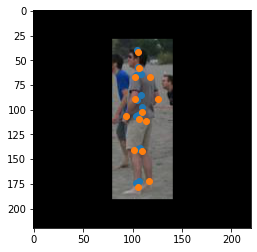

In [22]:
img_number = 102
plt.imshow(X_validation[img_number])
plt.scatter(test[img_number,0:14]*220, test[img_number,14:28]*220)
plt.scatter(Y_validation[img_number,0:14]*220, Y_validation[img_number,14:28]*220)

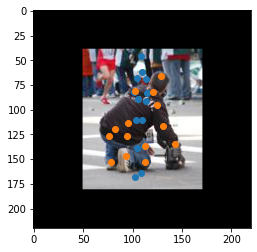

In [49]:
img_number = 10
plt.imshow(X_train[img_number])
plt.scatter(test[img_number,0:14]*220, test[img_number,14:28]*220)
plt.scatter(Y_train[img_number,0:14]*220, Y_train[img_number,14:28]*220)